# Teaching RL agents to play 3x3 TicTacToe by utilizing tabular Q-learning

In the framework of this project we aim to train RL agents to play the game of 3x3 TicTacToe. For choosing the optimal move of agents we utilize tabular Q-learning algorithm. The Q table is created during training on multiple games of TicTacToe between agents. We evaluate agents during and after training by the results of their game with the random agent to show the learning progress. 
<br>

The implementation of the training and evaluating procedures lies below.

## Essential imports 

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

from tictac_rl.train import game
from tictac_rl.tic_tac_toe_environment import TicTacToeEnvironment
from tictac_rl.agent import Agent

## Training

To achieve main goal (train RL agents to play TicTacToe) it was necessary to:
- Implement an environment that in response to actions on the part of the agent will return the changed state of the board and the reward
- Implement a random agent for out agents to evaluate on
- Implement a tabular Q-learning agents and train them

<br>
The implementation of this objectives is represented in the `tictac_rl` directory of the project. Please refer to it for more detailed information. 

<br>
Thus, for training we firstly create 2 agents:


In [82]:
eps = .1 # Defining the exploration rate 
agent_x = Agent('x', learning_rate=.1, eps=eps)
agent_o = Agent('o', learning_rate=.1, eps=eps)

x_win_rate = []
o_win_rate = []

`agent_x` is the agent that plays with `x` and the agent_o plays with  `o`. In addition to the symbol which the play with, the agents have the parameter of `learning rate`, which is a hyperparameter to be chosen, as well as `eps`.
<br>

We balance between the exploration and exploitation by utilizing the probability `eps`, with which the agents select a random action. With other words, we use epsilon-greedy approach for facilitating the "visiting" of the new states. 
<br>

Here we also initialize the variables to store information about win rates for further evaluation.

In [102]:
agent_x.learning_rate = 1e-3
agent_o.learning_rate = 1e-3
eps = .1

The training phase may be divided into several stages of general pipeline:
1. Validating the `x` agent against the random player on `n_validation_games`
2. Training the `x` agent for `n_games` against the `o` agent
3. Validating the `o` agent against the random player on `n_validation_games`
4. Training the `o` agent for `n_games` against the `x` player
<br>
The same procedure runs for `num_epoch` number of epochs. 
<br>

Now, to the training itself:

In [ ]:
num_epoch = 150
n_games = 2000
n_validation_games = 100  # validate on `n_validation_games` each epoch
plot_iter = 10  # plot every `plot_iter` games

for epoch in range(num_epoch):

    # Validation against random agent
    agent_x.eps = 0  # inference mode haha
    stats = {
        'x': 0,
        'o': 0,
        'tie': 0,
    }
    for i in range(n_validation_games):
        res, _ = game(TicTacToeEnvironment(Agent('o')), agent_x, train=False)
        stats[res] += 1
    x_win_rate.append(stats['x'] / n_validation_games)
    agent_x.eps = eps  # training mode    

    # Train x
    for i in trange(n_games):
        res, _ = game(TicTacToeEnvironment(agent_o), agent_x, train=True)

    # Validation against random agent
    agent_o.eps = 0  # inference
    stats = {
        'x': 0,
        'o': 0,
        'tie': 0,
    }
    for i in range(n_validation_games):
        res, _ = game(TicTacToeEnvironment(Agent('x')), agent_o, train=False)
        stats[res] += 1
    o_win_rate.append(stats['o'] / n_validation_games)
    agent_o.eps = eps

    # Train o
    for i in trange(n_games):
        res, _ = game(TicTacToeEnvironment(agent_x), agent_o, train=True)

As we don't want to lose any of results of the training, we save the agents to later use them for evaluation.

In [100]:
with open('models/trained_x.pkl', 'wb') as f:
    pickle.dump(agent_x, f)
with open('models/trained_o.pkl', 'wb') as f:
    pickle.dump(agent_o, f)

To verify that our agents indeed train during the above loop, we plot the learning_curve, which represents the number of wins between the agents and the random player on the evaluation part of the loop.

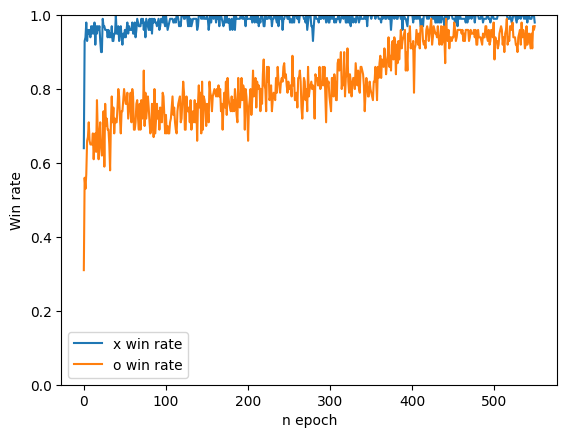

In [108]:
plt.plot(x_win_rate, label='x win rate')
plt.plot(o_win_rate, label='o win rate')
plt.legend()
plt.ylim(0, 1)
plt.xlabel('n epoch')
plt.ylabel('Win rate')
plt.savefig('media/learning_curve.pdf')

In [104]:
np.mean(x_win_rate[450:]), np.mean(o_win_rate[450:])

(0.9938000000000001, 0.9444999999999998)

As can be seen from results, `x` player learns pretty quickly and his win rate is very close to 100%, while the `o` player experience some issues. It can be explained by the `x`'s benefit of the first move, therefore for `o` it is harder to win. Exactly that results in the slower training of the `o` agent and in such final difference between win_rates: `0.99` for `x` and `0.94` for `o`.

## Comparison

Now let's compare how trained agents will behave themselves in the games against each other. 
<br>

Firstly, load the trained agents and set the exploration rate to 0, as during evaluation and comparison we do not need it.

In [122]:
with open('models/trained_x_gui.pkl', 'rb') as f:
    agent_x = pickle.load(f)
with open('models/trained_o_gui.pkl', 'rb') as f:
    agent_o = pickle.load(f)

# Inference
agent_x.eps = 0
agent_o.eps = 0

And now for the experiments!!!!!!!!!!

## Trained x-agent vs. random o-agent

We ran 1000 games between trained `x` and random `o` agents and counted the number of games in which each of them won.

In [120]:
stats = {
    'x': 0,
    'o': 0,
    'tie': 0,
}
n_games = 1_000

for i in trange(n_games):
    res, _ = game(TicTacToeEnvironment(Agent('o')), agent_x, train=False)
    stats[res] += 1

100%|██████████| 1000/1000 [00:00<00:00, 1007.82it/s]


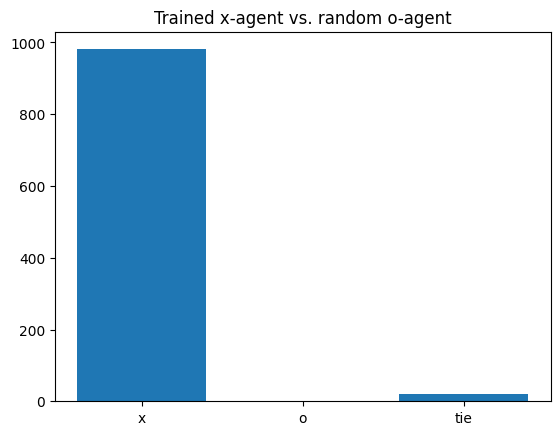

In [125]:
plt.bar(stats.keys(), stats.values())
plt.title('Trained x-agent vs. random o-agent')
plt.savefig('media/x_stats.pdf')

The results here are quite obvious: trained `x`-agent outperforms random `o`-agent in almost all of the cases, except several, where the game ended in a tie.

## Trained o-agent vs. random x-agent
We ran 1000 games between trained `o` and random `x` agents and counted the number of games in which each of them won.

In [114]:
stats = {
    'x': 0,
    'o': 0,
    'tie': 0,
}
n_games = 1_000

for i in trange(n_games):
    res, _ = game(TicTacToeEnvironment(Agent('x')), agent_o, train=False)
    stats[res] += 1

100%|██████████| 1000/1000 [00:01<00:00, 847.96it/s]


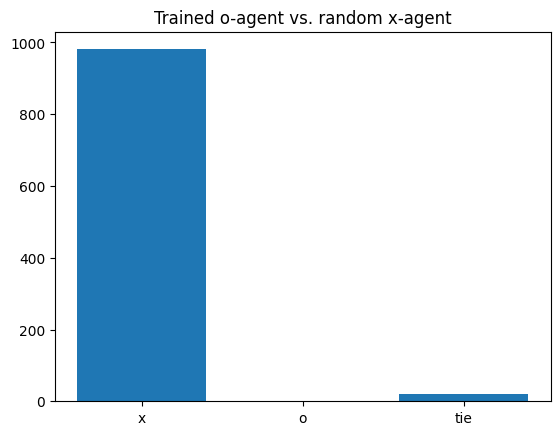

In [126]:
plt.bar(stats.keys(), stats.values())
plt.title('Trained o-agent vs. random x-agent')
plt.savefig('media/o_stats.pdf')

## Trained x-agent vs. trained o-agent
We ran 1000 games between trained `x` and trained `o` agents and counted the number of games in which each of them won.

In [127]:
stats = {
    'x': 0,
    'o': 0,
    'tie': 0,
}
n_games = 1_000

for i in trange(n_games):
    res, _ = game(TicTacToeEnvironment(agent_o), agent_x, train=False)
    stats[res] += 1

100%|██████████| 1000/1000 [00:01<00:00, 735.36it/s]


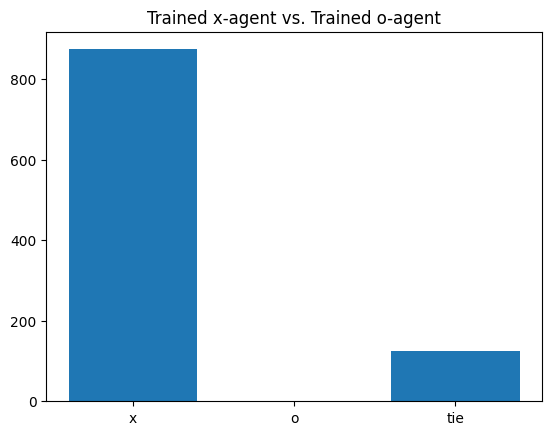

In [128]:
plt.bar(stats.keys(), stats.values())
plt.title('Trained x-agent vs. Trained o-agent')
plt.savefig('media/x_o_stats.pdf')

From the bar plot, it can be derived, that the trained `x` agent is actually trained better than his brother `o`. One of the causes of this might be the problem of the equal reward in case of the tie. For `o` agent it is much harder to win, taking into an account the priority of the `x`'s first  move. <br>

In ideal case, the game should always result in a tie, but we leave this goal for the prospect of the future work

# Conclusion
In this project, we successfully trained RL agents to play TicTacToe on a 3x3 board using the tabular Q-learning algorithm. The trained agents demonstrated the ability to make moves that are much better than just randomly filling the playing board.Therefore, the results show promising performance, but further improvements are needed for training the agents perfectly. One of the ideas for such improvements is the implementation of non-symmetrical award for `x`-s and `o`-s.
